In [1]:
%matplotlib inline

# Import packages and functions
import modelbase
import numpy as np
import pandas as pd
import os
import importlib
import sys
import re
import warnings
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm, CenteredNorm, SymLogNorm, Normalize
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import find_peaks, savgol_filter
from scipy.stats import iqr
from scipy.integrate import simpson
from scipy.optimize import minimize

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from sympy import Matrix, lambdify, linsolve, symbols
from warnings import warn
from os import listdir
from os.path import join
from functools import reduce
from operator import mul

# Helper functions
sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip

# Import model functions
from get_current_model import get_model
from module_update_phycobilisomes import add_OCP

# Get functions to evaluate minimisation results
from robustness_fit_parameters import get_fitting_parameter_dict, p_names

Aborted


In [2]:
from functions_custom_steady_state_simulator import simulate_to_steady_state_custom, _find_steady_state, get_response_coefficients, get_response_coefficients_array, get_response_coefficients_df, calculate_ss_Q_red, get_steadystate_y0

In [3]:
from functions_fluorescence_simulation import make_lights, make_adjusted_lights, create_protocol_NPQ, create_protocol_NPQ_short, create_protocol_noNPQ

In [4]:
# Get the new parameters that should be visualised
with open("../Results/minimise_202405291906_results.pickle", "rb") as f:
    fit = pickle.load(f)

new_parameters = get_fitting_parameter_dict(fit.x, p_names)

In [5]:
# Set to True to recalculate the results of analyses that take a long time
# Set to False to use pre-calculated results
settings = {
    "general":{
        # Set to True to plot/ recalculate all figures (VERY TIME INTENSIVE!)
        # Set to False to plot/ recalculate no figure
        # Set to None to use figure specific settings (below)

        "plot_all": True, 
        "recalculate_all": True,

        # Use multiprocessing
        "multiprocessing": True,
        "max_workers": os.cpu_count() - 2,
    },
    # Figure specific settigs (overwritten by above settings)
    # Recalculation time with Intel Core i7, 16 cores, 64 GB memory
    "MCA":                          {"recalculate": False, "plot": True}, # Recalculation time: 30 min
    "CO2_fluxes_spectral":          {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "open_PS2s":                    {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "state_transitions_PAM":        {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "state_transitions_analysis":   {"recalculate": False, "plot": True}, # Recalculation time: 150 min
    "CO2_fluxes_monochrom":         {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "CO2_fluxes_monochrom_adapted": {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "sink_production_monochrom":    {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "PAM_blue_light":               {"recalculate": False, "plot": True}, # Recalculation time: 2 min
    "PAM_all_lights":               {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "electron_pathways":            {"recalculate": False, "plot": True}, # Recalculation time: 7 min
    "O2_CO2_fluxes":                {"recalculate": False, "plot": True}, # Recalculation time: 1 min
}

# Set the paths to save figures and objects
figure_path = Path("../Figures/robustness_visualisation")
results_path = Path("../Results/robustness_visualisation")

default_results_path = Path("../Results")

plot_format = ["svg", "png"]

# Reduce or increase the number of simulated points in appropriate analyses (1=default amount)
fraction_simulated_points = 0.3

In [6]:
# Apply general settings
for k,v in settings.items():
    if k!= "general":
        if settings["general"]["recalculate_all"] is not None:
            v["recalculate"] = settings["general"]["recalculate_all"]
        if settings["general"]["plot_all"] is not None:
            v["plot"] = settings["general"]["plot_all"]
        settings[k] = v

In [7]:
# Define a function to get a model with updated parameters
def get_model_new_parameters(*args, p=new_parameters, **kwargs):
    # Get the model
    res = get_model(*args, **kwargs)

    # Separate model and initial conditions if both are returned
    if isinstance(res, tuple):
        m,y0 = res
    else:
        m,y0 = res, None

    # Update the parameters
    m.update_parameters(p)
    return (m,y0) if y0 is not None else m

In [8]:
# Save the used parameters in Results for later traceability
with open(results_path / "used_parameters.pickle", "wb") as f:
    pickle.dump(new_parameters, f)

# Carbon Dioxide Fluxes under Different Light Sources (Figure 3b)

In [9]:
def get_ssflux(m, y0, lightfun, target, light_params, tolerance=1e-4, rel_norm=False):
    light = lightfun(*light_params)
    s = Simulator(m.copy())
    s.update_parameter("pfd", light)
    s.initialise(y0)
    # t,y = s.simulate_to_steady_state(tolerance=tolerance, rel_norm=rel_norm, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        return np.nan
    else:
        return float(s.get_fluxes_dict()[target])

def get_ssfluxes(m, y0, lightfun, target, lightparam1, lightparam2, multiprocessing=True, max_workers=None):
    light_params = np.meshgrid(lightparam1, lightparam2)
    _light_params = zip(*[x.flatten() for x in light_params])

    _get_ssflux = partial(get_ssflux, m, y0, lightfun, target)

    if sys.platform in ["win32", "cygwin"] or not multiprocessing:
        res = np.array(list(map(_get_ssflux, _light_params)), dtype=float)
    else:
        with ProcessPoolExecutor(max_workers=max_workers) as pe:
            res = np.array(list(pe.map(_get_ssflux, _light_params)), dtype=float)

    res = res.reshape(-1,len(lightparam1))
    return pd.DataFrame(res, index=lightparam2, columns=lightparam1)

In [10]:
# Get a model and fix the 3PGA concentration for steady-state analyses 
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

m_MCA,y0 = get_model_new_parameters(check_consistency=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

lights = {"solar": "Solar Light", "fluorescent_lamp": "Fluorescent Lamp", "cool_white_led": "Cool White LED", "warm_white_led": "Warm White LED"}
intens = np.linspace(20, 500, int(50 * fraction_simulated_points))
if settings["CO2_fluxes_spectral"]["recalculate"]:
    CO2s = get_ssfluxes(
        m_MCA, 
        y0, 
        lip.light_spectra, 
        "vCCM", 
        list(lights.keys()), 
        intens,
        multiprocessing = settings["general"]["multiprocessing"],
        max_workers = settings["general"]["max_workers"],
    )

    fnc.save_obj_dated(CO2s, "spectra_ss_CO2s", results_path)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten


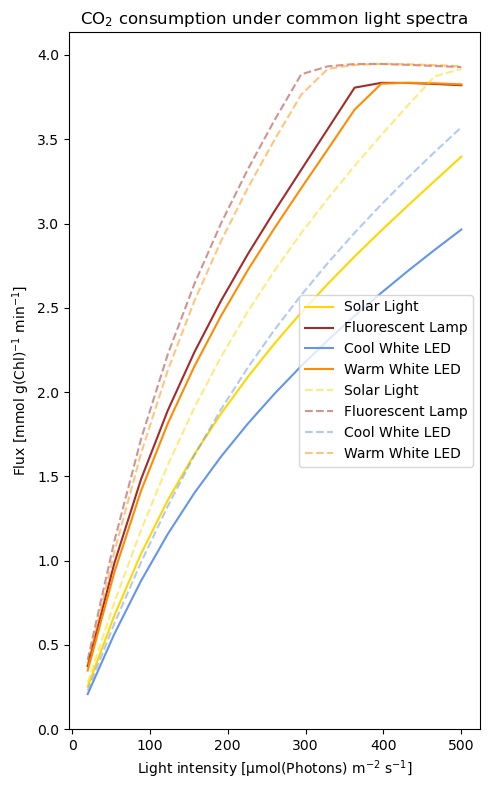

In [11]:
if settings["CO2_fluxes_spectral"]["plot"]:
    CO2s = fnc.load_obj_dated("spectra_ss_CO2s", results_path)
    CO2s_def = fnc.load_obj_dated("spectra_ss_CO2s", default_results_path) # Load results with default parameters

    labels = lights.values()
    colors = ["gold", "brown", "cornflowerblue", "darkorange"]

    fig, ax = plt.subplots(figsize=(5,8))
    ax.set_prop_cycle('color',colors)
    ax.plot(CO2s * prm.unit_conv(['mmol mol(Chl)-1 -> mmol g(Chl)-1', "s-1 -> min-1"]), label = labels)
    ax.plot(CO2s_def * prm.unit_conv(['mmol mol(Chl)-1 -> mmol g(Chl)-1', "s-1 -> min-1"]), label = labels, ls="--", alpha=0.5)
    ax.set_ylabel('Flux [mmol g(Chl)$^{-1}$ min$^{-1}$]')
    ax.set_xlabel('Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]')
    ax.set_title("CO$_2$ consumption under common light spectra")
    ax.legend(loc="center right", fontsize=10)
    ax.set_ylim(ymin=0)
    fig.tight_layout()
    fnc.savefig_dated(fig, "CO2underspectrallight", type=plot_format, path=figure_path)

# Open Photosystems Ratio (Figure 7)
Comparison to Miller *et al.* (2021)

In [12]:
if settings["open_PS2s"]["recalculate"]:
    lights = np.append(0, np.linspace(100, 700, 30))
    sims = {}
    openPSII = pd.Series(index=lights, dtype=float)
    for i, j in enumerate(lights):
        m,y0 = get_model_new_parameters(check_consistency=False, verbose=False)
        m = fnc.add_exchange(m)
        s = Simulator(m)
        s.initialise(y0)
        s.update_parameter("pfd", lip.light_spectra("fluorescent_lamp", j))
        # t,y = s.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
        s,t,y = simulate_to_steady_state_custom(s,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
        sims[i] = s

        if t is not None:
            openPSII.iloc[i] = s.get_full_results_df().loc[:,["B0", "B1"]].sum(axis=1, skipna=False) / m.get_parameter("PSIItot")
    
    fnc.save_obj_dated(openPSII, "openps2s", results_path)

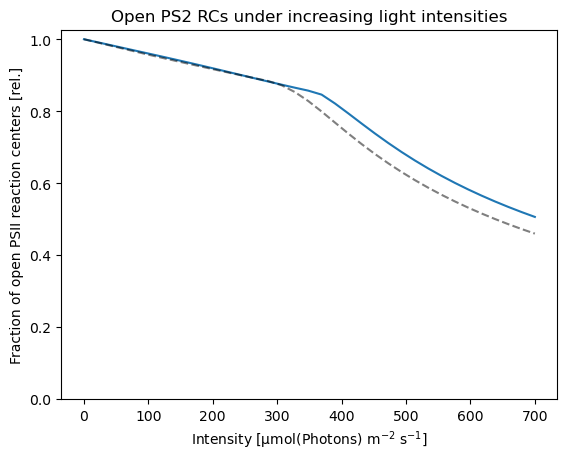

In [13]:
if settings["open_PS2s"]["plot"]:
    openPSII = fnc.load_obj_dated("openps2s", results_path)
    openPSII_def = fnc.load_obj_dated("openps2s", default_results_path) # Load results with default parameters

    fig, ax = plt.subplots()
    ax.plot(openPSII)
    ax.plot(openPSII_def, ls="--", alpha=0.5, c="k")
    ax.set_ylim(ymin=0)
    ax.set_xlabel("Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    ax.set_ylabel("Fraction of open PSII reaction centers [rel.]")
    ax.set_title("Open PS2 RCs under increasing light intensities")
    fnc.savefig_dated(fig, "openps2s", type=plot_format, path=figure_path)

In [14]:
# Plotting functions
def add_phasebox(ax, t_start, t_end, text, height, ylow=1, adj_plotheight=False, fontsize=7):
    box = Rectangle(
        [t_start, ylow],
        t_end-t_start,
        height,
        fill=False,
        ec="k",
    )
    ax.add_patch(box)
    ax.text(
        t_start + 0.5*(t_end-t_start),
        ylow+0.5*height,
        text,
        ha="center",
        va="center",
        fontsize=fontsize
    )
    if adj_plotheight:
        ax.set_ylim(ymax=ax.get_ylim()[1]+height)
    return ax

def add_insetbox(ax, xmin, xmax, ymin, ymax, adj_plotheight=None):
    height = ymax-ymin
    box = Rectangle(
        [xmin, ymin],
        xmax-xmin,
        height,
        fill = False,
        fc="w",
        ec="k",
        transform = ax.transAxes
    )
    ax.add_patch(box)
    if adj_plotheight is not None:
        adj_y = np.array(ax.get_ylim()) + np.array(adj_plotheight)
        ax.set_ylim(adj_y)
    return ax

def annotate_phases_statetrans(ax):
    cycles = np.array([3,3,15,15])
    times = np.cumsum(cycles * 20)
    ax = add_phasebox(ax, 0, times[0], "D", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, times[0], times[1], "S1", 0.05, 1.02)
    ax = add_phasebox(ax, times[1], times[2], "S2", 0.05, 1.02)
    ax = add_phasebox(ax, times[2], times[3], "S1", 0.05, 1.02)

    return ax

# Pulse Amplitude Modulation (PAM) measurements with saturation pulse method
## PAM-SP under of 435 nm adapted strain (Figure 2a)

In [15]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

### Get the PAM and strain data

In [16]:
def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,str(light)] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,str(growthlight)]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,str(growthlight)]), fraction_is_monomers=True, output_is_monomers=False)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    return res

def _plot_model_and_data(s, data, sim_offset=None, data_offset=None, ax=None):
    # Initialise a plot
    if ax is None:
        fig, ax = plt.subplots(**fnc.plt_defaults["figure"])
    else:
        fig = ax.figure

    # Align data and model using an offset
    if sim_offset is None:
        time = s.get_time()
    elif s.get_time()[0] != (-sim_offset):
        time = np.array(s.get_time())- (s.get_time()[0] + sim_offset)
    else:
        time = s.get_time()

    # Plot the data
    dat = data/data.max().max()
    dat_time = dat.index

    if data_offset is not None:
        dat_time -= data_offset
    dat_line = ax.plot(dat_time, dat.values, c="firebrick", label="Measurement")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Fluorescence [rel.]")
    ax.set_ylim(ymin=0)

    # Plot the simulation on top
    fluo = s.get_full_results_dict()["Fluo"]
    fluo_norm = fluo / fluo.max()
    sim_line = ax.plot(time, fluo_norm, c="black", label="Simulation")

    if len(dat_line)>1:
        handles = sim_line + dat_line[0]
    else:
        handles = sim_line + dat_line

    ax.legend(
        handles = handles,
        loc="center right",
        bbox_to_anchor = (1,0.85)
    )

    return fig, ax

def plot_model_and_data(s, data, pulse_pfd, ax=None, sim_offset=None, data_offset=None, **lightbar_kwargs):
    figs={}

    # Data plot
    col_select_kw = "^F"
    col_select = [i for i,x in enumerate(data.columns) if re.search(col_select_kw, x)]
    col_selectnam = data.columns[col_select]
    plot_data = data.loc[10:data.index[-1]-10, col_selectnam[:-1]]

    s_trim = fnc.remove_beginning_from_simulation(s, 300)

    fig,ax = _plot_model_and_data(s_trim, plot_data, sim_offset=sim_offset, data_offset=data_offset, ax=ax)
    ax = fnc.add_lightbar(s_trim, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, **lightbar_kwargs)

    return fig, ax

def annotate_electron_pathways(ax, epath):
    ypos = epath.cumsum(axis=1) - (epath/2)

    for y,s in zip(ypos.to_numpy().flatten(), epath.to_numpy().flatten()):
        ax.text(x=0, y=y, s=np.round(s,3), ha='center', va='center')
    return ax

def ss_analysis(m, light_int=100, light_wl=659):
    sslight = lip.light_gaussianLED(light_wl, light_int)
    mss = m.copy()
    mss.update_parameter("pfd", sslight)

    # Initialise the model
    sss=Simulator(mss)
    sss.initialise(y0)
    t,y = sss.simulate(10000)

    # plot_overview_isoATP(sss)
    epath = fnc.get_ss_electron_pathways(sss)
    epath = epath/float(epath.sum(axis=1, skipna=False))
    ax = epath.plot(kind="bar", stacked=True)

    # Annotate the bars
    ax = annotate_electron_pathways(ax,epath)
    return sss, [ax], epath

In [17]:
# Get the fluorescence data paths
DIRPATH = Path("../Code/data")
PAMPATH = DIRPATH / "PAM_Slow_kinetics_files_Zavrel2021"
file_names = listdir(PAMPATH)
file_paths = np.array([join(PAMPATH, file_name) for file_name in file_names])

In [18]:
# Extract the measurement type from the file name, use to group replicates
meas_types = np.array([re.sub(r"([0-9]+)_[0-9]+\.[csvCSV]+", "\\1", x) for x in file_names])
meas_types_set = list(set(meas_types))
meas_types_set.sort()

In [19]:
# Load and preprocess all data
pamdata = {}

for meas_select in  meas_types_set:
    file_paths_select = file_paths[meas_types == meas_select]

    # Create a container for the combined data
    meas_data = pd.DataFrame([])

    # Iterate through the files
    for i,file_path in enumerate(file_paths_select):
        # Adapt the file reading parameters depending on the file structure
        if meas_select.startswith("PSI+PSII kinetics"):
            skiprows = 1
        else:
            skiprows = 0
        
        # Read the file and remove empty columns
        file_data = pd.read_csv(file_path, sep=";",skiprows=skiprows, index_col=0)
        file_data=file_data.loc[:,np.invert(np.all(np.isnan(file_data), axis=0))]

        if i == 0:
            # Save the common column names
            col_names = file_data.columns

        # Combine replicates
        meas_data = meas_data.join(file_data, rsuffix=f"_{i}", how="outer")

    # Exclude all data points that are nor present in all datasets
    excl_data = meas_data.iloc[list(np.invert(np.isnan(meas_data).any(axis=1))),:]
    excl_data.shape
        
    # Normalise the Data to its highest point
    norm_data = excl_data.copy()
    norm_data = norm_data / norm_data.max()

    # Set the normalised data as analysis data
    data = norm_data

    # # Calculate the mean over selected columns
    # for col_name in col_names:
    #     col_select = [bool(re.search(col_name, x)) for x in data.columns]
    #     col_mean = data.iloc[:,col_select].mean(axis=1, skipna=False).rename(f"{col_name}_mean")

    #     # Add to the dataframe
    #     data = data.join(col_mean)
    
    # Store the data
    pamdata[meas_select] = data

# Extract the growth lights
growthlights = set([re.sub("^.*([0-9]{3})$","\\1",meas_select) for meas_select in meas_types_set])

In [20]:

# Get the strain-specific parameters
dat = pd.read_csv(DIRPATH / "Strainparameters_Zavrel2021.csv", skiprows=1, index_col=0).iloc[:,2:]

# Get the concentration data
# dat_conc = dat.loc[dat.loc[:,"Unit"].str.match("fg cell-1"), :]
dat_conc = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
dat_conc.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']

# Convert to [mg mg(Chla)^-1]
dat_conc = dat_conc.div(dat_conc.iloc[0,:]) # convert to [mg mg(Chla)^-1]
dat_conc.loc[:,"Unit"] = "mg mg(Chla)^-1"

# Get the photosystems data
dat_PS = dat.loc[["PSI / PSII"],:]

# Get the phycobilisome data
dat_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
dat_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]


# Calculate the strain parameters
strain_params = {}
strain_export = {}

for growthlight in dat.columns:
    # Get the strain specific parameters
    strain_param = get_strain_parameters(
        df_pigments=dat_conc,
        df_PBS=dat_PBS,
        df_PS1_PS2=dat_PS,
        growthlight=growthlight,
        pbs_relfluo={"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    )

    MChl = 893.509 # [g mol^-1]
    absorption_coef = lip.get_pigment_absorption(strain_param["pigment_content"]).sum(axis=1) * MChl # [m^2 mmol(Chl)^-1]

    # Get the PAM sample Chl concentration
    # Estimated from a later measurement where OD600 = 0.8, the PAM samples had 0.6
    OD800_Chlconc = pd.read_excel(DIRPATH/"Chlorophyll, total car.xlsx", skiprows=1).iloc[1:,].loc[:,["Sample", "Chlorophyll a"]]
    OD800_Chlconc.loc[:,"Sample"] = OD800_Chlconc.loc[:,"Sample"].str.removesuffix(" nm")
    OD800_Chlconc = OD800_Chlconc.groupby("Sample").mean()
    OD800_Chlconc.head() # [mol (10 ml)^-1]

    indexmapping = {idx1:idx2 for idx1,idx2 in zip(dat.columns, OD800_Chlconc.index)}

    # Convert the chlorophyll concentration units
    cuvette_Chlconc = ( # [mmol(Chl) m^-3]
        float(OD800_Chlconc.loc[indexmapping[str(growthlight)]]) # [mol (10 ml)^-1]
        / 10 # [ml]
        * 1e3 # [mol mmol^-1]
        * 1e6 # [ml m^-3]
        * 0.3 / 0.8 # [rel] OD of the PAM sample
    )

    # Save the data
    strain_params[growthlight] = {
        "params": strain_param,
        "cuvette_Chlconc": cuvette_Chlconc
    }

### Model the data

In [21]:

lights = make_lights(blue_wl=480)
lights_adj = make_adjusted_lights(absorption_coef, cuvette_Chlconc)
dark_adj, low_blue_adj, high_blue_adj, orange_adj, pulse_orange_adj, pulse_blue_adj = lights_adj

# Get the pfd of the pulses
pulse_pfd = np.min([simpson(x) for x in [pulse_orange_adj, pulse_blue_adj]])

In [22]:
def complex_absorption(pfd, ps_ratio, pigment_content):
    absorption = lip.get_pigment_absorption(pigment_content)
    association = lip.get_pigment_association(
        ps_ratio,
        beta_carotene_method="stoichiometric",
        pigments=pigment_content,
        verbose=False,
    )

    M_chl = 893.509  # [g mol^-1] molar mass of chlorophyll a (C55H72MgN4O5)

    return (
        lip.get_complex_absorption(pfd, absorption, association) * M_chl
    )  # [µmol(Photons) mmol(Chl)^-1 s^-1]

### Simulate all of the datasets (435 & 633nm light in two light protocols)

In [23]:
sims = {}
sims_def = {}

# Select the measurement to simulate
for meas_select in meas_types_set:
    growthlight = int(meas_select[-3:])

    print("Measurement: ", meas_select, "\nSimulated light: ", growthlight,"\n")

    strain_param = strain_params[str(growthlight)]["params"]
    cuvette_Chlconc = strain_params[str(growthlight)]["cuvette_Chlconc"]

    # Get the latest model version
    m4,y0 = get_model_new_parameters(check_consistency=False, reduced_size=False)

    # ADAPTION TO THE STRAIN
    y0.update({"PSII":strain_param["PSIItot"]})
    m4.update_parameters(
        strain_param
    )

    # Change the CO2 concentration to 400ppm as experiments were conducted in air
    m4.update_parameter("CO2ext_pp", 0.0004)

    # Initialise the model
    s4=Simulator(m4)
    s4.initialise(y0)

    # Simulate the appropriate protocol
    pulse_pfdm4 = 2600 * 2
    lights_lowpulse = make_adjusted_lights(
        absorption_coef=absorption_coef, 
        chlorophyll_sample=cuvette_Chlconc, 
        lights=make_lights(pulseInt=pulse_pfdm4, blue_wl=480)
    )
    if meas_select.startswith("PSII kinetics, NPQ at state 2"):
        protocol4 = create_protocol_noNPQ(*lights_lowpulse)
    else:
        protocol4 = create_protocol_NPQ(*lights_lowpulse)

    if settings["PAM_blue_light"]["recalculate"]:
        s4 = fnc.simulate_protocol(s4, protocol4, retry_unsuccessful=True)
        fnc.save_Simulator_dated(s4, f"Zavrel2021sim{meas_select[-5:]}", path=results_path, save_fluxes=True, save_full_results=True)
    else:
        print("loading simulation")
        s4 = fnc.load_Simulator_dated(name = f"Zavrel2021sim{meas_select[-5:]}", path=results_path, date=None)
    
    sims[meas_select] = s4

    sims_def[meas_select] = fnc.load_Simulator_dated(name = f"Zavrel2021sim{meas_select[-5:]}", path=default_results_path, date=None)

Measurement:  PSII kinetics, NPQ at state 1_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 1_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 2_435 
Simulated light:  435 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Measurement:  PSII kinetics, NPQ at state 2_633 
Simulated light:  633 

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light repr

In [24]:
def add_phaseboxes_NPQ(ax):
    ax = add_phasebox(ax, 0, 95.3, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 95.3, 215.6, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 215.6, 395.9, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 395.9, 576.2, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 576.2, 756.5, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 756.5, 1000, "NPQ relaxation", 0.05, 1.02)
    return ax

def add_phaseboxes_noNPQ(ax):
    ax = add_phasebox(ax, 0, 95.3, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 95.3, 215.6, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 215.6, 515.9, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 515.9, 695.5, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 695.5, 935, "NPQ relaxation", 0.05, 1.02)
    return ax

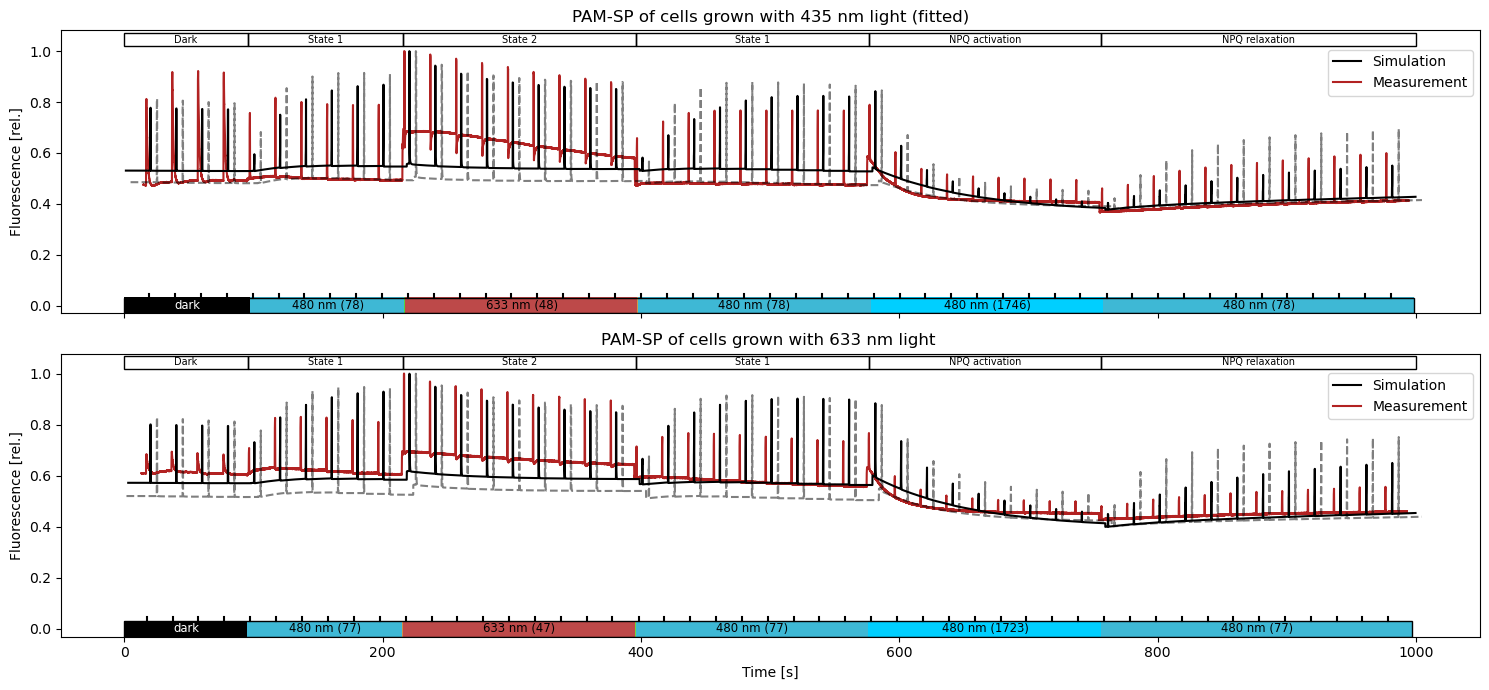

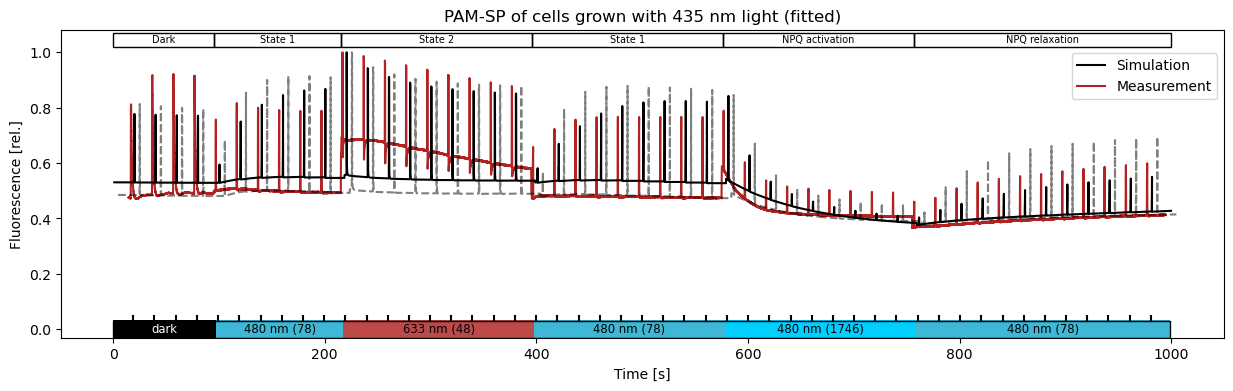

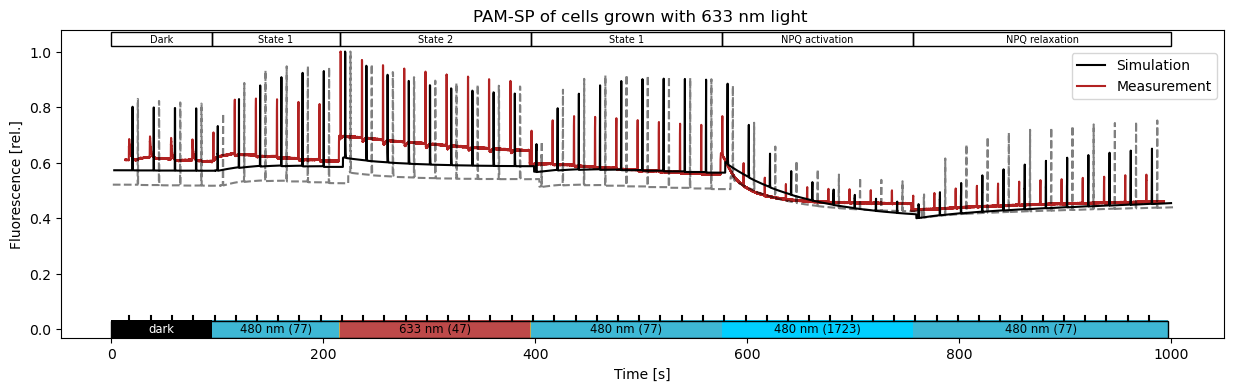

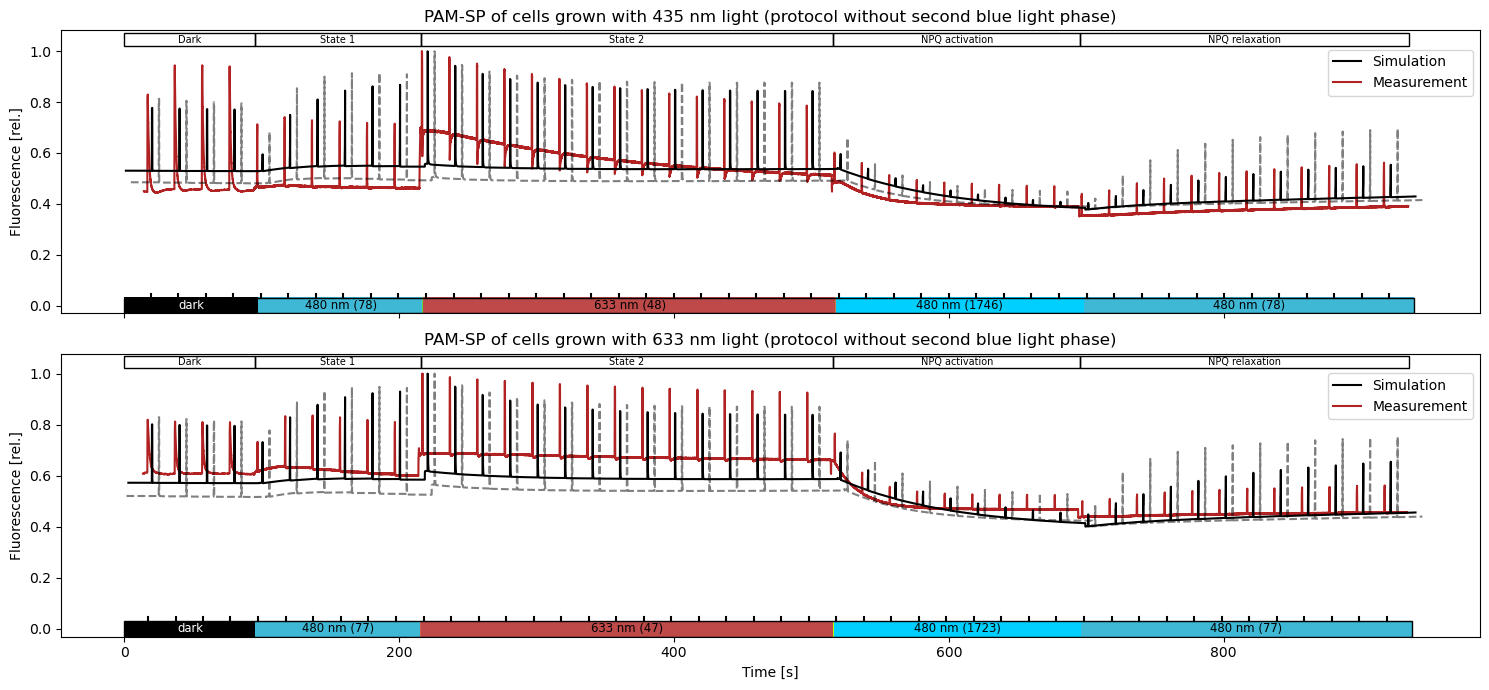

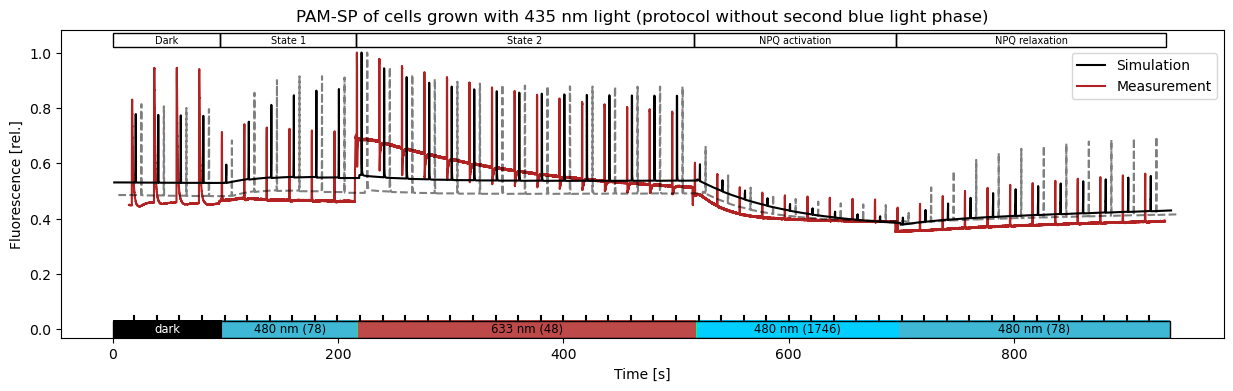

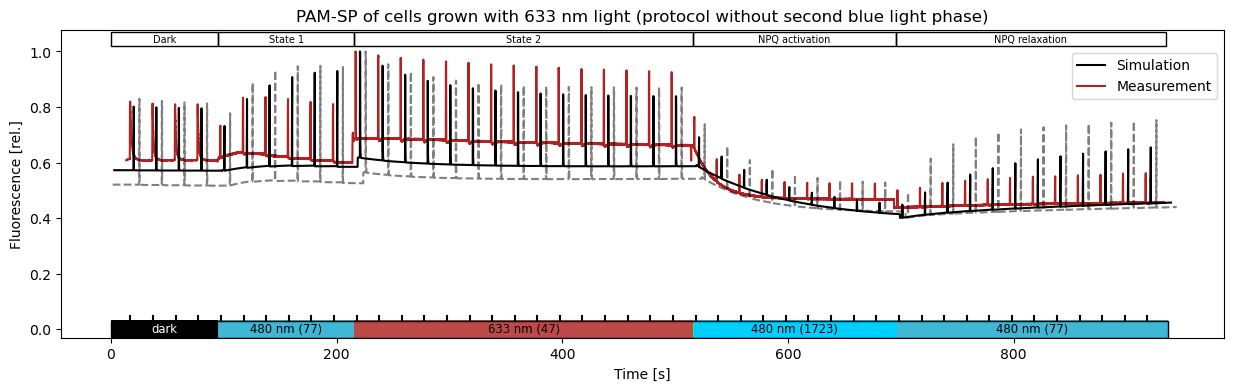

In [25]:
if settings["PAM_blue_light"]["plot"]:
    combined_plots = {
        "state_1":['PSII kinetics, NPQ at state 1_435', 'PSII kinetics, NPQ at state 1_633'],
        "state_2":['PSII kinetics, NPQ at state 2_435', 'PSII kinetics, NPQ at state 2_633'],
        }
    data_offsets = { # Determine the first peak and set it to time 18
        x:pamdata[x].index[pamdata[x].loc[:20,"F"].argmax()] - 17 for x in pamdata 
    }

    for key_comp, meas_comb in combined_plots.items():
        fig_comb, axes_comb = plt.subplots(2,1, figsize=(10,12), sharex=True)
        # fig_det, axes_det = plt.subplots(2,1, figsize=(20,12), sharex=True)
        for meas_select in meas_comb:
            if meas_select in sims.keys():
                s4 = sims[meas_select]
                s4_def = sims_def[meas_select]

                fig, _ax = plt.subplots(figsize=(10, 5))
                axes = [_ax, axes_comb[meas_comb.index(meas_select)]]

                for i,ax in enumerate(axes):
                    fig, ax = plot_model_and_data(s4, pamdata[meas_select].iloc[:,:2], pulse_pfdm4 * 0.95, ax=ax, annotation_twoline=False, data_offset=data_offsets[meas_select])

                    # Get the fluorescence with default parameters
                    _s4_def = fnc.remove_beginning_from_simulation(s4_def, 295)
                    default_fluo = _s4_def.get_full_results_df().loc[:,"Fluo"]
                    ax.plot(default_fluo/default_fluo.max(), ls="--", alpha=0.5, c="k")

                    # Set the title
                    title_suffix = ""

                    if meas_select == 'PSII kinetics, NPQ at state 1_435':
                        title_suffix += "(fitted)"

                    if meas_select.split("_")[0] == 'PSII kinetics, NPQ at state 2':
                        title_suffix += "(protocol without second blue light phase)" #", Light Protocol "
                        ax = add_phaseboxes_noNPQ(ax)
                    else:
                        ax = add_phaseboxes_NPQ(ax)

                    ax.set_title(f"PAM-SP of cells grown with {meas_select.split('_')[1]} nm light {title_suffix}")

                    if i == 0:
                        fig.set_size_inches(15,4)
                        fnc.savefig_dated(fig, f"pamspplot_{meas_select[15:]}", type=plot_format, path=figure_path, bbox_inches="tight")

                # # Plot the redox state and CBB redox activation
                # ax = axes_det[meas_comb.index(meas_select)]
                # _s4 = fnc.remove_beginning_from_simulation(s4, 300)
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["Q_red"]/_s4.model.parameters["Q_tot"], label="Reduced PQ fraction")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["PSIIq"]/_s4.model.parameters["PSIItot"], label="State transition activity")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["CBBa"], label="CBB redox activation")
                # ax.plot(_s4.get_time(), _s4.get_full_results_df()["OCP"], label="OCP activity")

                # ax = fnc.add_lightbar(_s4, ax, 1800, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, annotation_twoline=False)

                # ax.legend()

                # ax.set_title(f"Detailed analysis of PAM-SP of cells grown with {meas_select.split('_')[1]} nm light {title_suffix}")
                # fig_det.tight_layout()


            axes_comb[0].set_xlabel(None)
            fig_comb.tight_layout()
            fig.set_size_inches(15,7)


            fnc.savefig_dated(fig_comb, f"pamspplot_combined_{key_comp}", type=plot_format, path=figure_path, bbox_inches="tight")


## Simulate all wavelengths (Figure 2b)

In [26]:
def simulate_adapted_strain_pam(growthlight, strain_params, fit_param, absorption_coef, pulse_pfd, meas_select):
    print(f"{growthlight}: started")
    strain_param = strain_params[str(growthlight)]["params"]
    cuvette_Chlconc = strain_params[str(growthlight)]["cuvette_Chlconc"]

    # Get the latest model version
    m4,y0 = get_model_new_parameters(check_consistency=False, reduced_size=False, verbose=False)

    # ADAPTION TO THE STRAIN
    y0.update({"PSII":strain_param["PSIItot"]})
    m4.update_parameters(
        strain_param
    )

    # Initialise the model
    s4=Simulator(m4)
    s4.initialise(y0)

    # Temporarily adapt parameters
    m4.update_parameters(fit_param)

    # Simulate the appropriate protocol
    lights_lowpulse = make_adjusted_lights(
        absorption_coef=absorption_coef, 
        chlorophyll_sample=cuvette_Chlconc, 
        lights=make_lights(pulseInt=pulse_pfd, blue_wl=480)
    )
    if meas_select.startswith("PSI+PSII kinetics"):
        protocol4 = create_protocol_noNPQ(*lights_lowpulse)
    else:
        protocol4 = create_protocol_NPQ(*lights_lowpulse)

    s4 = fnc.simulate_protocol(s4, protocol4, retry_unsuccessful=True)
    print(f"{growthlight}: finished")

    return fnc._convert_Simulator_for_save(s4, save_full_results=True)

In [27]:
if settings["PAM_all_lights"]["recalculate"]:
    # Simulate PAM traces for all adapted strains with the above fit parameters
    wavelengths = [x for x in strain_params.keys() if x != "596"]

    _simulate_adapted_strain_pam = partial(
        simulate_adapted_strain_pam,
        strain_params=strain_params,
        fit_param={},
        absorption_coef=absorption_coef,
        pulse_pfd=pulse_pfdm4,
        meas_select=meas_select
    )
    if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
            res = list(map(_simulate_adapted_strain_pam, wavelengths))
    else:
        with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
            res = list(pe.map(_simulate_adapted_strain_pam, wavelengths))
    sims = {k:fnc._create_Simulator_for_load(v) for k,v in zip(wavelengths, res)}
    fnc.save_Simulator_dated(sims, "adapted_strain_pam", results_path, save_full_results=True)

435: started465: started495: started


555: started520: started633: started
687: started


663: started
555: finished
520: finished
495: finished
465: finished
435: finished
633: finished
663: finished
687: finished


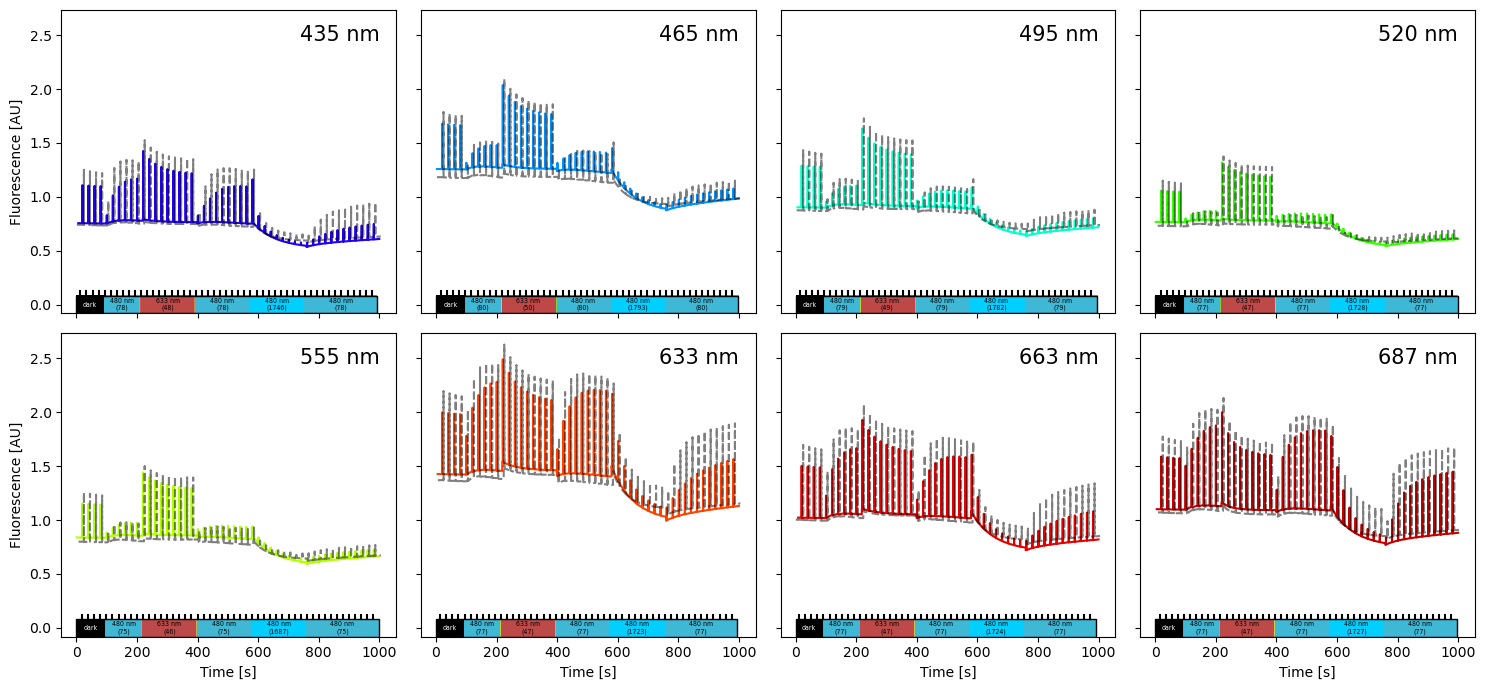

In [28]:
if settings["PAM_all_lights"]["plot"]:
    # Plot the PAM simulations
    sims = fnc.load_Simulator_dated("adapted_strain_pam", results_path)
    sims_def = fnc.load_Simulator_dated("adapted_strain_pam", default_results_path)

    fig, axes = plt.subplots(2,4, figsize = (15,7), sharey=True, sharex=True)

    sims = {k:fnc.remove_beginning_from_simulation(s, 300) for k,s in sims.items()}
    sims_def = {k:fnc.remove_beginning_from_simulation(s, 295) for k,s in sims_def.items()}

    for ax, (i,s), s_def in zip(axes.flatten(), sims.items(), sims_def.values()):
        try:
            ax.plot(s.get_full_results_df().loc[:,"Fluo"], c=fnc.wavelength_to_rgb(int(i)))
            ax.plot(s_def.get_full_results_df().loc[:,"Fluo"], ls="--", alpha=0.5, c="k")
        except:
            pass
        ax.text(0.95, 0.95, f"{i} nm", size=15, ha="right", va="top", transform=ax.transAxes)
    ax.set_ylim(ymin=0)
        
    for ax, (i,s) in zip(axes.flatten(), sims.items()):
        ax = fnc.add_lightbar(s, ax, 2000, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, y_pos=0, annotation=True, annotation_twoline=True, annotation_size=4.5)

    for j in range(4):
        axes[-1,j].set_xlabel("Time [s]")
    for j in range(2):
        axes[j,0].set_ylabel("Fluorescence [AU]")

    fig.tight_layout()
    fnc.savefig_dated(fig, "adapted_strain_pam", type=plot_format, path=figure_path)

## Validation PAM experiment

In [29]:
df = pd.read_csv(Path("../Code/data/PAM_validation_Zavrel2024.csv"), index_col=[0], header=[0,1,2])
idx = pd.IndexSlice

In [30]:
# Protocol of the validation experiment
dark, low_blue, high_blue, orange, pulse_orange, pulse_blue = make_lights(
    blueInt=80,
    orangeInt=50,
    highblueInt=1800,
    pulseInt=15000,
    orange_wl=625,
    blue_wl=440,
)
pulse_white = lip.light_spectra("cool_white_led", 15000)


# Dark acclimation
protocol = fnc.create_protocol_const(
    light=dark,
    time=300
)

# Dark phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(dark, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=4,
    final_actinic_time=5
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Orange phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(orange, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=10,
    first_actinic_time=25,
    final_actinic_time=5,
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# High blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(high_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Blue phase
protocol = fnc.create_protocol_PAM(
    init=protocol,
    actinic=(low_blue, 30-0.6),  # Actinic light intensity and duration
    saturating=(
        pulse_white,
        0.6,
    ),  # Saturating pulse light intensity and duration
    cycles=6,
    first_actinic_time=25,
    final_actinic_time=5
)

# Simulate the validation experiment
m,y0 = get_model_new_parameters()
s = Simulator(m)
s.initialise(y0)

# The culture is grown under 1% CO2
s.update_parameter("CO2ext_pp", 0.01)

s = fnc.simulate_protocol(s, protocol, retry_unsuccessful=True)


# Simulate the validation experiment
m_def,y0 = get_model()
s_def = Simulator(m_def)
s_def.initialise(y0)

# The culture is grown under 1% CO2
s_def.update_parameter("CO2ext_pp", 0.01)

s_def = fnc.simulate_protocol(s_def, protocol, retry_unsuccessful=True)

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False
updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


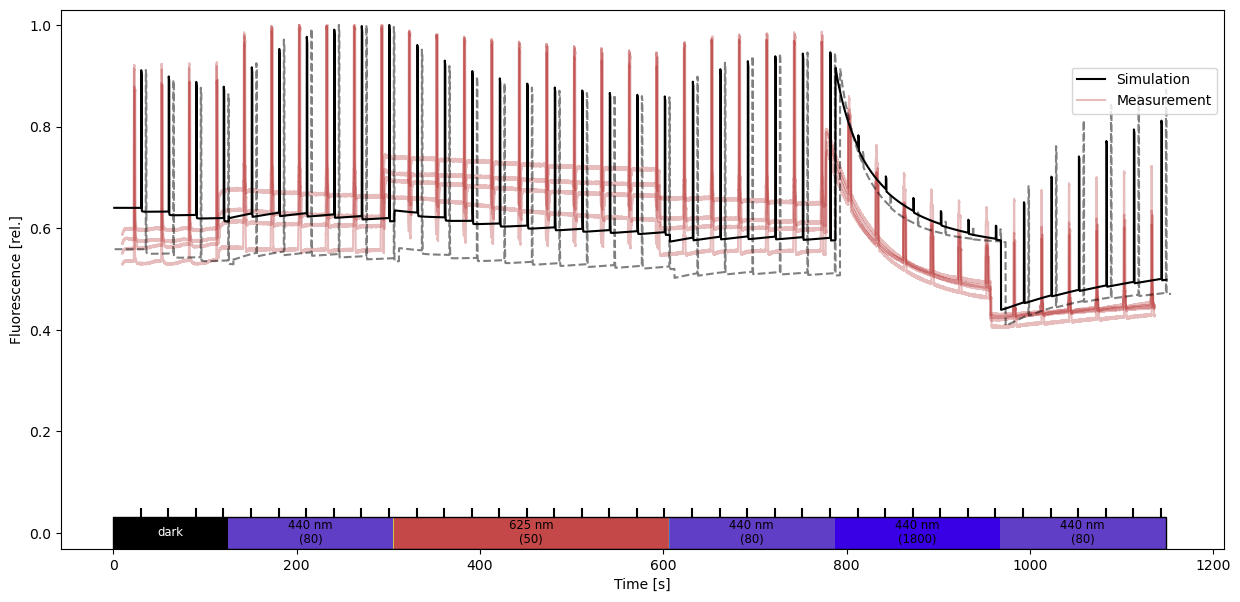

In [31]:
idx = pd.IndexSlice
_s = fnc.remove_beginning_from_simulation(s, 299)
_s_def = fnc.remove_beginning_from_simulation(s_def, 294)

fig,ax= plt.subplots(figsize=(15,7))
dat = df.loc[:1126,idx["25", "white",:]]
dat_line = ax.plot(dat.index.to_numpy() + 10, dat.values, c="firebrick", label="Measurement", alpha=0.3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Fluorescence [rel.]")
ax.set_ylim(ymin=0)

# Plot the simulation on top
fluo = _s.get_full_results_dict()["Fluo"]
fluo_norm = fluo / fluo.max()
sim_line = ax.plot(_s.get_time(), fluo_norm, c="black", label="Simulation")

fluo_def = _s_def.get_full_results_dict()["Fluo"]
fluo_norm_def = fluo_def / fluo_def.max()
ax.plot(_s_def.get_time(), fluo_norm_def, ls="--", alpha=0.5, c="k")

handles = sim_line + [dat_line[0]]

ax.legend(
    handles = handles,
    loc="center right",
    bbox_to_anchor = (1,0.85)
)

ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0)
ax.set_title("")
fnc.savefig_dated(fig, f"pamspplot_validation_singleplot", type=plot_format, path=figure_path, bbox_inches="tight")

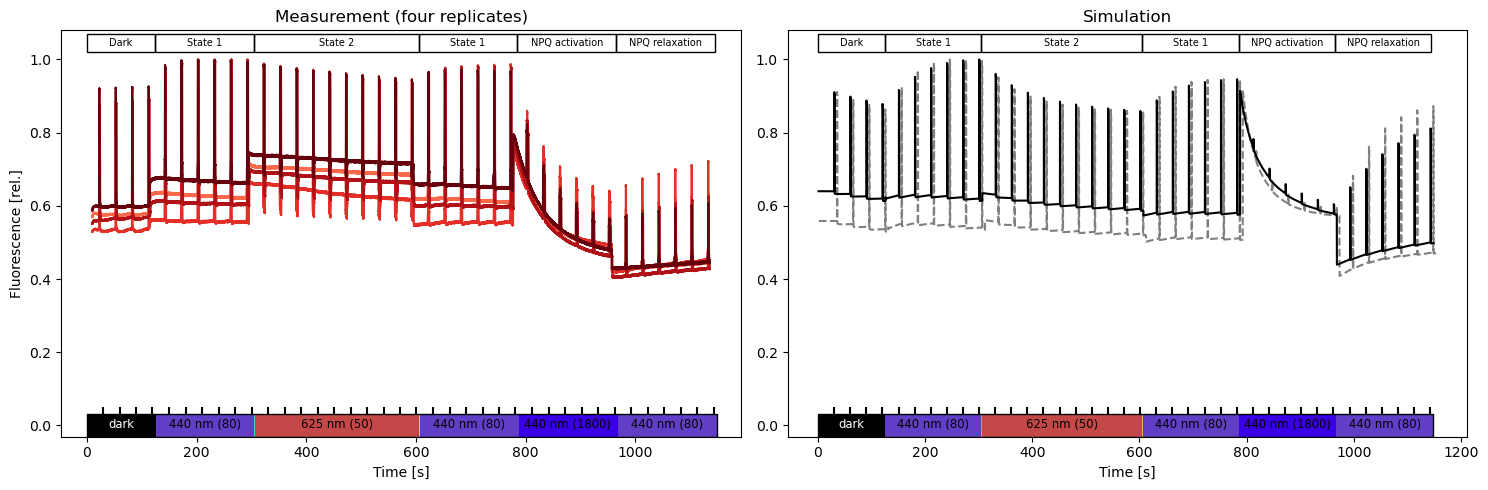

In [32]:
idx = pd.IndexSlice
_s = fnc.remove_beginning_from_simulation(s, 299)
_s_def = fnc.remove_beginning_from_simulation(s_def, 294)

fig,axes= plt.subplots(1,2, figsize=(15,5))
dat = df.loc[:1126,idx["25", "white",:]]

colors = mpl.colormaps["Reds"](np.linspace(0.5,1,len(dat.columns)))
for i in range(len(dat.columns)):   
    dat_line = axes[0].plot(dat.index.to_numpy() + 10, dat.iloc[:,i], c=colors[i], label="Measurement")
axes[0].set_ylabel("Fluorescence [rel.]")
axes[0].set_title("Measurement (four replicates)")


# Plot the simulation on the side
fluo = _s.get_full_results_dict()["Fluo"]
fluo_norm = fluo / fluo.max()
sim_line = axes[1].plot(_s.get_time(), fluo_norm, c="black", label="Simulation")
axes[1].set_title("Simulation")

fluo_def = _s_def.get_full_results_dict()["Fluo"]
fluo_norm_def = fluo_def / fluo_def.max()
axes[1].plot(_s_def.get_time(), fluo_norm_def, ls="--", alpha=0.5, c="k")

for ax in axes:
    ax.set_xlabel("Time [s]")
    ax.set_ylim(ymin=0)
    ax = fnc.add_lightbar(_s, ax, pulse_pfd * 0.95, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, annotation_twoline=False)
    
    
    # Add phaseboxes
    ax = add_phasebox(ax, 0, 125, "Dark", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, 125, 305, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 305, 605, "State 2", 0.05, 1.02)
    ax = add_phasebox(ax, 605, 785, "State 1", 0.05, 1.02)
    ax = add_phasebox(ax, 785, 965, "NPQ activation", 0.05, 1.02)
    ax = add_phasebox(ax, 965, 1145, "NPQ relaxation", 0.05, 1.02)

# Share the y axis
axes[0].sharey(axes[1])
# axes[1].set_yticklabels([])

fig.tight_layout()
fnc.savefig_dated(fig, f"pamspplot_validation_dualplot", type=plot_format, path=figure_path, bbox_inches="tight")

In [33]:
# Simulate all
def get_pathways_at_lights(model, y0, lights, intens):
    sims = []
    for i, light in zip(intens, lights):
        m = model.copy()
        m.update_parameter("pfd", light)

        # Prepare for ss simulation
        exch_dict = {
            "3PGA": {"k": 10, "thresh": 1000},
            # "PG": {"k": 10, "thresh": 1},
        }
        m =fnc.add_exchange(m, exch_dict)

        s = Simulator(m)
        s.initialise(y0)
        # t,y = s.simulate(10000)
        # t,y = s.simulate_to_steady_state(tolerance=1e-2)
        s,t,y = simulate_to_steady_state_custom(s,        simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-7], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])

        if t is None:
            raise RuntimeError(f"simulation failed for i={i:.2f}")
        else:
            sims.append(s)

    # Get the electron pathways
    pathways = pd.DataFrame({i:pd.DataFrame(fnc.get_ss_electron_pathways(s)).iloc[-1,:] for s,i in zip(sims, intens)}).T
    return pathways, sims

def get_model_simulator(model, y0, light):
    m = model.copy()
    m.update_parameter("pfd", light)

    # Prepare for ss simulation
    exch_dict = {
        "3PGA": {"k": 10, "thresh": 1000},
    }
    m =fnc.add_exchange(m, exch_dict)

    s = Simulator(m)
    s.initialise(y0)
    return s

# Electron Pathway and Validation Experiments (Figure 1, 6, & 8)

## Evaluate the electron pathways at different light intensities (Figure 1 & 8)

In [34]:
normToPS1 = True

intens = np.linspace(0.1, 320, int(100 * fraction_simulated_points))
light_source = "Theune2021"
if light_source == "Theune2021":
    lights = [lip.light_gaussianLED(670, i) for i in intens]
else:
    lights = [lip.light_spectra(light_source, i) for i in intens]

# Simulate Wild Type and different mutants
# Standard model
m0, y0 = get_model_new_parameters(check_consistency=False, verbose=False)

# low CO2
mCO2, y0 = get_model_new_parameters(check_consistency=False, verbose=False)
mCO2.update_parameter("CO2ext_pp", 0.0004)

# Flv KO mutant
mFlv, y0 = get_model_new_parameters(check_consistency=False, verbose=False)
mFlv.update_parameter("k_O2", 0)

# Flv KO mutant
mNQ, y0 = get_model_new_parameters(check_consistency=False, verbose=False)
mNQ.update_parameter("k_NQ" if "k_NQ" in mNQ.parameters else "vNQ_max", 0)

models = {"m0":m0, "mCO2":mCO2, "mFlv":mFlv, "mNQ":mNQ}
pathways = {}
sims = {}

if settings["electron_pathways"]["recalculate"]:
    print("\nSIMULATING")
    for key,model in models.items():
        print(key)
        _pathways, _sims = get_pathways_at_lights(model, y0, lights, intens)
        pathways[key] = _pathways
        sims[key] = _sims

        fnc.save_Simulator_dated(_sims, f"epaths_sims_{key}", results_path)
    fnc.save_obj_dated(pathways, "epaths_paths", results_path)


SIMULATING
m0
mCO2
mFlv
mNQ


In [35]:
# Make the models with default parameters
# Simulate Wild Type and different mutants
# Standard model
m0_def, y0 = get_model(check_consistency=False, verbose=False)

# low CO2
mCO2_def, y0 = get_model(check_consistency=False, verbose=False)
mCO2_def.update_parameter("CO2ext_pp", 0.0004)

# Flv KO mutant
mFlv_def, y0 = get_model(check_consistency=False, verbose=False)
mFlv_def.update_parameter("k_O2", 0)

# Flv KO mutant
mNQ_def, y0 = get_model(check_consistency=False, verbose=False)
mNQ_def.update_parameter("k_NQ" if "k_NQ" in mNQ.parameters else "vNQ_max", 0)

models_def = {"m0":m0_def, "mCO2":mCO2_def, "mFlv":mFlv_def, "mNQ":mNQ_def}

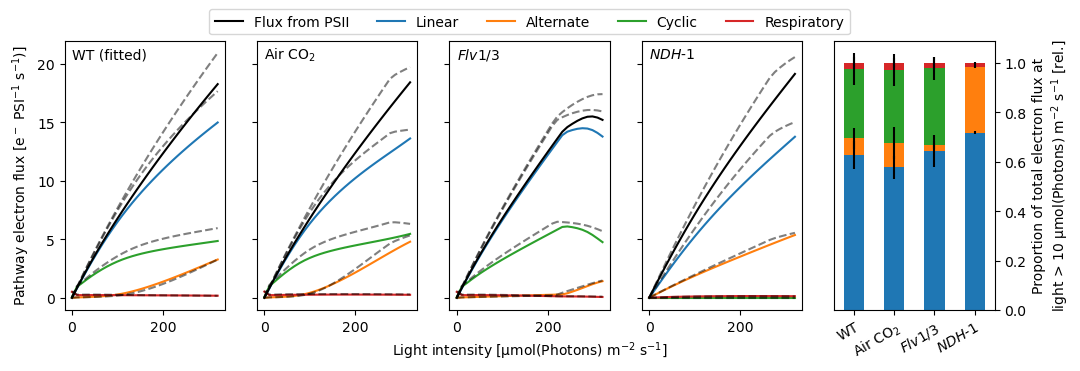

In [36]:
if settings["electron_pathways"]["plot"]:
    sims = {key:fnc.load_Simulator_dated(f"epaths_sims_{key}", results_path) for key in models}
    pathways = fnc.load_obj_dated("epaths_paths", results_path)

    sims_def = {key:fnc.load_Simulator_dated(f"epaths_sims_{key}", default_results_path) for key in models}
    pathways_def = fnc.load_obj_dated("epaths_paths", default_results_path)

    # Plot all
    titles = {
        "m0":"WT",
        "mFlv":"$\it{Flv1/3}$",
        "mNQ": "$\it{NDH}$-$\it{1}$",
        "mCO2": "Air CO$_2$"
    }
    
    # Set up a figure with all axes shared but the last one
    fig = plt.figure()
    axes = np.full(len(titles)+1,0, dtype=object)
    axes[0] = fig.add_subplot(1,len(titles)+1,1)
    for i in range(2,len(titles)+2):
        axes[i-1] = fig.add_subplot(1,len(titles)+1,i, sharey=(axes[0] if i!=5 else None))

    fig.set_size_inches(12,3.5)

    # Line Plot
    for (key, ptw), ptw_def, ax in zip(pathways.items(), pathways_def.values(), axes):
        norm = m0.get_parameter("PSItot") *3 if normToPS1 else 1 # Normalise to PS1 monomers
        ptw_norm = ptw / norm
        vps2 = pd.Series([s.get_fluxes_df().loc[:,"vPS2"].iloc[-1] for s in sims[key]], index=intens) * 2 / norm

        lin = ax.plot(ptw_norm)
        lin2 = ax.plot(vps2, c="k", label = "PS2 flux")

        # Add line with default parameters
        ptw_norm_def = ptw_def / norm
        vps2_def = pd.Series([s.get_fluxes_df().loc[:,"vPS2"].iloc[-1] for s in sims_def[key]], index=intens) * 2 / norm
        ax.plot(ptw_norm_def, ls="--", alpha=0.5, c="k")
        ax.plot(vps2_def, ls="--", alpha=0.5, c="k")

    for (key, ptw), ax in zip(pathways.items(), axes):
        ax.text(0, ax.get_ylim()[1]*0.93, titles[key] + (" (fitted)" if key == "m0" else ""))

    if normToPS1:
        axes[0].set_ylabel("Pathway electron flux [e$^-$ PSI$^{-1}$ s$^{-1}$)]")
    else:
        axes[0].set_ylabel("Pathway electron flux [mmol(e$^-$) mol(Chl)$^{-1}$ s$^{-1}$)]")

    axes[2].set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    axes[2].legend(
            handles=lin2 + lin,
            labels=["Flux from PSII", "Linear", "Alternate", "Cyclic", "Respiratory"], 
            loc="center",
            bbox_to_anchor= (0.5, 1.07),
            borderaxespad= 0,
            ncol=5
            )
    
    # Calculate mean pathway usage
    pathway_mean = {}
    pathway_sd = {}

    for mdl in pathways.keys():
        pathway_mean[mdl] = (pathways[mdl].loc[10:,:].T / pathways[mdl].sum(axis=1)).T.mean(axis=0)
        pathway_sd[mdl] = (pathways[mdl].loc[10:,:].T / pathways[mdl].sum(axis=1)).T.std(axis=0)

    pathway_mean = pd.DataFrame(pathway_mean)
    pathway_sd = pd.DataFrame(pathway_sd)

    # Create a container for the y errors
    yerr = [[row, row] for i,row in pathway_sd.iterrows()]

    pathway_mean.T.plot.bar(stacked=True, yerr=yerr, ax=axes[-1])
    
    # Remove the legend
    axes[-1].get_legend().remove()

    # Set the y axis to the right
    axes[-1].yaxis.set_label_position("right")
    axes[-1].yaxis.tick_right()
    axes[-1].set_ylabel("Proportion of total electron flux at\nlight > 10 µmol(Photons) m$^{-2}$ s$^{-1}$ [rel.]")

    axes[-1].set_xticklabels([titles[x] for x in pathway_mean.columns], rotation=30, ha="right", rotation_mode='anchor')

    fig.tight_layout()
    fnc.savefig_dated(fig, f"electronpaths-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")

    
    # for mdl in pathways.keys():
    #     # Relative pathway fractions
    #     fig, ax = plt.subplots()

    #     (pathways[mdl].T / pathways[mdl].sum(axis=1)).T.plot(ax=ax)
    #     ax.set_ylabel("Proportion of total electron flux [rel.]")
    #     ax.set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    #     ax.text(0, ax.get_ylim()[1]*0.93, titles[mdl])

    #     fnc.savefig_dated(fig, f"electronpaths-{light_source}{mdl}_rel", type=plot_format, path=figure_path, bbox_inches="tight")

    # # Relative pathway fractions (single plot)
    # fig, ax = plt.subplots(figsize=(5,5))
    # pathway_mean.T.plot.bar(stacked=False, yerr=yerr, ax=ax)
    # ax.set_ylabel("Proportion of total electron flux [rel.]")

    # fig.suptitle("Relative electron pathway amounts (I>10 µmol(Photons) m$^{-2}$ s$^{-1}$)")

    # fnc.savefig_dated(fig, f"electronpaths-{light_source}_relbar", type=plot_format, path=figure_path, bbox_inches="tight")


    # # Detailed analysis
    # allpHs = {}
    # allcomps = {}
    # allvs = {}
    # # allKeqs = {}

    # for mdl in sims:
    #     idx = intens
    #     pHs = pd.DataFrame(columns =["pHlumen", "pHcytoplasm"])
    #     comps = pd.DataFrame(columns =["ATP", "NADPH", "Q_red", "Fd_red"])
    #     vs =  pd.DataFrame(columns =["vATPsynthase", "vNQ", "vCBB"])

    #     for i,s in enumerate(sims[mdl]):
    #         pHs.loc[idx[i],:] = s.get_full_results_df()[pHs.columns].iloc[-1]
    #         comps.loc[idx[i],:] = s.get_full_results_df()[comps.columns].iloc[-1] / np.array([s.model.get_parameter(x) for x in ["AP_tot", "NADP_tot", "Q_tot","Fd_tot"]])
    #         vs.loc[idx[i],:] = s.get_fluxes_df()[vs.columns].iloc[-1]    

    #     allpHs[mdl] = pHs
    #     allcomps[mdl] = comps
    #     allvs[mdl] = vs
    
    # # Plot of in depth analysis
    # fig, axes = plt.subplots(3,4, sharey="row", sharex=True, figsize=(10,7))
    # for (k,v), ax in zip(allcomps.items(), axes[0,:]):
    #     lin0 = ax.plot(v, label=list(["ATP", "NADPH", "PQ$_{red}$", "Fd$_{red}$"]))
    #     ax.set_title(titles[k])
    #     ax.set_ylim(0,1.05)
    # for (k,v), ax in zip(allpHs.items(), axes[1,:]):
    #     lin1 = ax.plot(v, label=list(["Lumen","Cytoplasm"]))
    # for i, ((k,v), ax) in enumerate(zip(allvs.items(), axes[2,:])):
    #     lin21 = ax.plot(v.iloc[:,:-1], label=["ATP synthase", "NDH-1"])
    #     ax2 = ax.twinx()
    #     lin22= ax2.plot(v["vCBB"], label="CBB", c=mpl.colormaps["tab10"](2))
    #     if i>0:
    #         ax2.sharey(_ax2)
    #     if i<2:
    #         ax2.tick_params(labelright=False)
    #     _ax2 = ax2
        

    # axes[0,0].set_ylabel("Fraction of total pool")
    # axes[1,0].set_ylabel("pH")
    # axes[2,0].set_ylabel("Flux [mmol mol(Chl)$^{-1}$ s$^{-1}$]")
    # fig.text(0.4,0,"Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", ha="center",va="center")
    # ax2.set_ylabel("CBB Flux[mmol mol(Chl)$^{-1}$ s$^{-1}$]")

    # for i, lin in zip(range(axes.shape[0]), [lin0, lin1, lin21+lin22]):
    #     y = 1.04 if i < 2 else 1.33 # 1.1
    #     axes[i,-1].legend(handles=lin,bbox_to_anchor=(y,1), loc="upper left")

    # fig.tight_layout()
    # fnc.savefig_dated(fig, f"electronpaths_analysis-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")

## Calculate the cell's NPQ, simulating fluorescence

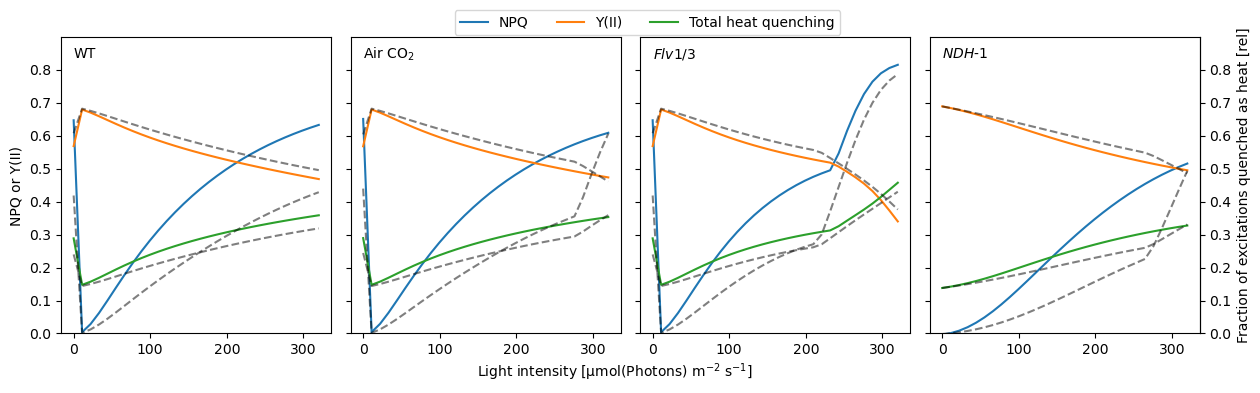

In [37]:
fig, axes = plt.subplots(1,4, figsize=(12,3.5), sharey=True)

plot_kwargs = [{}, {"ls":"--", "alpha":0.5, "c":"k"}]

for j, (_sims, _models) in enumerate(zip([sims, sims_def], [models, models_def])):
    for mdl, ax in zip(_sims.keys(), axes.flatten()):
        OCPs = np.zeros(len(_sims[mdl]))
        NPQs = np.zeros(len(_sims[mdl]))
        YIIs = np.zeros(len(_sims[mdl]))
        Heat = np.zeros(len(_sims[mdl]))

        # Get Fm as the SP after a FR light phase
        _s = Simulator(_models[mdl])
        _s.initialise(y0)
        _s.update_parameter("pfd", lip.light_gaussianLED(700, 50))
        _s.simulate(300)
        _s.update_parameter("pfd", lip.light_gaussianLED(633, 15000))
        _s.simulate(300+0.6)
        Fm = _s.get_full_results_df().loc[300:,"FPS2"].max()

        for i,s in enumerate(_sims[mdl]):
            # Get the necessary dynamic variables and parameters
            OCP, B0, B1, B2, B3, PSIIq, Ft  = list(s.get_full_results_df().loc[:,["OCP", "B0", "B1", "B2", "B3", "PSIIq", "FPS2"]].to_numpy().flatten())
            kH0, kHst, kF, k2, PSIItot = [s.model.get_parameter(x) for x in ["kH0", "kHst", "kF", "k2", "PSIItot"]]

            kH = kH0 + kHst * (PSIIq / PSIItot)

            # Simulate the fluorescence with a SP
            _s = s.copy()
            _s.update_parameter("pfd", lip.light_gaussianLED(633, 15000))

            t_end = s.get_time()[-1]
            _s.simulate(t_end+0.6)
            Fmp = _s.get_full_results_df().loc[t_end:,"FPS2"].max()

            # Fluorescence-like NPQ (Fm - Fm') / Fm'
            NPQs[i] = (Fm - Fmp) / Fmp

            # Fluorescence-like Y(II) (Fm' - Ft) / Fm'
            YIIs[i] = (Fmp - Ft) / Fmp

            # Heat quenching
            Heat[i] = (kH) / (kH + kF + k2) * (B1 / (B1 + B3)) + (kH) / (kH + kF) * (B3 / (B1 + B3))

        ax.plot(intens, NPQs, label="NPQ" if j==0 else None, **plot_kwargs[j])
        ax.plot(intens, YIIs, label="Y(II)" if j==0 else None, **plot_kwargs[j])
        ax.plot(intens, Heat, label="Total heat quenching" if j==0 else None, **plot_kwargs[j])
        # ax.plot(intens, OCPs, label="OCP")

ax.set_ylim(0, ax.get_ylim()[1]*1.05)

fig.tight_layout()

ax2 = ax.secondary_yaxis(location="right")
ax2.set_ylabel("Fraction of excitations quenched as heat [rel]")
axes[0].set_ylabel("NPQ or Y(II)")
axes[1].legend( 
        loc="center",
        bbox_to_anchor= (1.1, 1.05),
        borderaxespad= 0,
        ncol=5
        )

fig.text(x=0.5, y=0, s="Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]", ha="center", va="center")

for mdl, ax in zip(_sims.keys(), axes.flatten()):
    ax.text(0, ax.get_ylim()[1]*0.93, titles[mdl])

fnc.savefig_dated(fig, f"electronpaths_processes-Theune2021", type=plot_format, path=figure_path, bbox_inches="tight")


## Compare Oxygen and CO2 fluxes (Figure 6)

In [38]:
def get_O2andCO2rates(s):
    #  Get O2 and CO2 rates
    rates = {}
    res = {}

    rates["O2"] = fnc.get_stoichiometric_fluxes(s, "O2")
    rates["O2"].pop("vO2out")

    rates["CO2"] = fnc.get_stoichiometric_fluxes(s, "CO2")
    rates["CO2"].pop("vCCM")

    for cmp in ["O2", "CO2"]:
        prod = pd.DataFrame(rates[cmp].copy())
        prod[prod<0] = 0
        res[f"{cmp}_production"] = prod.sum(axis=1, skipna=False)

        cons = pd.DataFrame(rates[cmp].copy())
        cons[prod>0] = 0
        res[f"{cmp}_consumption"] = cons.sum(axis=1, skipna=False)

        res[f"{cmp}_net"] = pd.DataFrame(rates[cmp]).sum(axis=1, skipna=False)
    
    return pd.DataFrame(res)

In [39]:
# Oxygen change rates from Schuurmans2014
O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

In [40]:
# Reference values for plot
# Oxygen change rates from Schuurmans2014
O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

# Define the lights
intens = np.unique(np.sort(np.concatenate((np.linspace(0, 320, 30), O2_ref.index.to_numpy()))))
lights = [lip.light_gaussianLED(625, i) for i in intens]

# Standard model
m0,y0 = get_model_new_parameters(check_consistency=False, verbose=False)

# Standard model
mlowCO2,y0 = get_model_new_parameters(check_consistency=False, verbose=False)
mlowCO2.update_parameter("CO2ext_pp", 0.0004)

# Adjust the lights to in-culture conditions (2 mg(Chl) l^-1 according to Schuurmans)
MChl = 893.509 # [g mol^-1]
absorption_coef = lip.get_pigment_absorption(m0.parameters["pigment_content"]).sum(axis=1) * MChl
lights = lip.get_mean_sample_light(
    lights, # [µmol(Photons) m^-2 s^-1]
    depth = 0.01,  # [m]
    absorption_coef=absorption_coef,
    chlorophyll_sample=(
        2 # [mg(Chl) l^-1] (Schuurmans2014)
        / MChl # [mol g^-1]
        * 1e3
    ) # [mmol(Chl) m^-3]
)

models = {"m0":m0, "mlowCO2":mlowCO2}
pathways = {}
sims = {}
gasrates = {}

if settings["O2_CO2_fluxes"]["recalculate"]:
    for key,model in models.items():
        print(key)
        _pathways, _sims = get_pathways_at_lights(model, y0, lights, intens)
        pathways[key] = _pathways
        sims[key] = _sims

        # Get the O2 and CO2 rates for Wild Type
        gasrates[key] = pd.concat([get_O2andCO2rates(s).iloc[-1,:] for s in _sims], axis=1)
        gasrates[key].columns = [f"{i:.2f}" for i in intens]
    fnc.save_obj_dated(gasrates, "gasrates_validation", results_path)

m0
mlowCO2


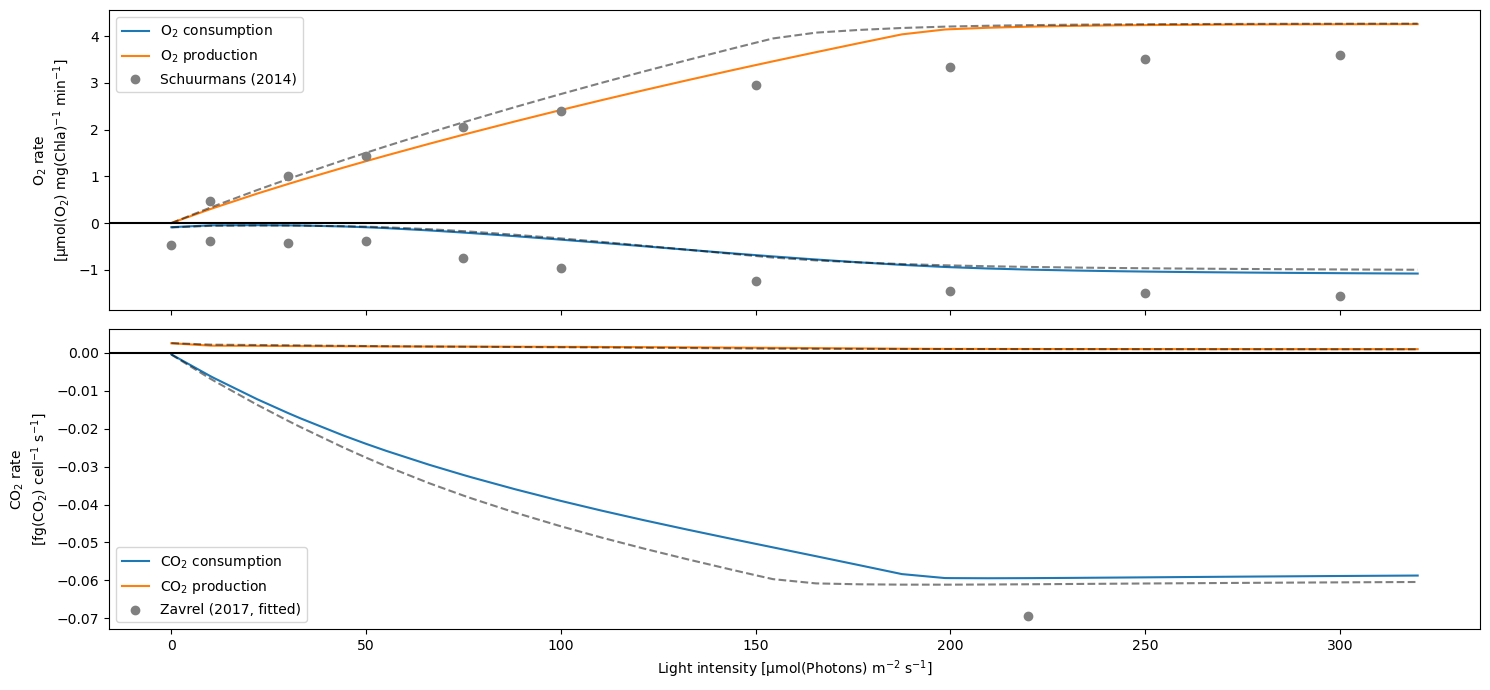

In [41]:
if settings["O2_CO2_fluxes"]["plot"]:
        
    gasrates = fnc.load_obj_dated("gasrates_validation", results_path)
    gasrates_def = fnc.load_obj_dated("gasrates_validation", default_results_path)

    # Reference values for plot
    # Oxygen change rates from Schuurmans2014
    O2_ref = pd.read_csv("../Code/data/O2rates_Schuurmans2014.csv", skiprows=1, index_col=0)

    # Carbon fixation rate from Zavrel2017
    CBB_rate = (
        -0.2 # [fg(CO2) cell^-1 s^-1]
        / 60 # [fg(Chla) cell^-1]
        / prm.M_CO2 # [g(CO2) mol^-1]
        * prm.M_chl # [g(Chl) mol^-1]
        * 1e3
        * 1e15
    )
    CBB_ref = (220, CBB_rate * prm.unit_conv("mmol mol(Chl)-1 -> g(CO2) cell-1")) # [g(CO2) cell^-1 s^-1] approximate maximal CO2 uptake rate (Zavrel2017; Fig. S-D)

    fig, axes = plt.subplots(2,1, figsize = (15,7), sharex=True)



    # Oxygen plot
    for mdl in ["m0"]:
        ax = axes[0]
        lins1 = ax.plot(intens, gasrates[mdl].loc[["O2_consumption","O2_production"]].T * prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), label = ["O$_2$ consumption","O$_2$ production"]) 
        
        # Add the lines with default parameters
        ax.plot(intens, gasrates_def[mdl].loc[["O2_consumption","O2_production"]].T * prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), ls="--", alpha=0.5, c="k") 
        # ax.secondary_yaxis(functions=(
        #     lambda x: x/prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), 
        #     lambda x: x*prm.unit_conv(["mmol mol(Chl)-1 -> mmol g(Chl)-1", "s-1 -> min-1"]), 
        #     ), location="right")
        ax.axhline(0,c="k")
        lins2 = ax.plot(O2_ref.loc[:,[" prod_625_highCO2", " cons_625_highCO2"]], "o", c="grey", label="Schuurmans (2014)")
        # lins3 = ax.plot(O2_ref.loc[:,[" prod_625_lowCO2", " cons_625_lowCO2"]], "o", c="grey", label="Schuurmans (2014) Low CO2")

        ax.set_ylabel("O$_2$ rate\n[µmol(O$_2$) mg(Chla)$^{-1}$ min$^{-1}$]")

        to_legend = lins1 + [lins2[0]]
        ax.legend(to_legend, [x.get_label() for x in to_legend])

        ax = axes[1]
        ax.plot(intens, gasrates[mdl].loc[["CO2_consumption","CO2_production"]].T * 1e15 * prm.unit_conv("mmol mol(Chl)-1 -> g(CO2) cell-1"), label = ["CO$_2$ consumption","CO$_2$ production"]) 
        
        # Add the lines with default parameters
        ax.plot(intens, gasrates_def[mdl].loc[["CO2_consumption","CO2_production"]].T * 1e15 * prm.unit_conv("mmol mol(Chl)-1 -> g(CO2) cell-1"), ls="--", alpha=0.5, c="k") 
        # ax.secondary_yaxis(functions=(
        #     lambda x: x/1e15/prm.unit_conv(["mmol mol(Chl)-1 -> g(CO2) cell-1"]), 
        #     lambda x: x*1e15*prm.unit_conv(["mmol mol(Chl)-1 -> g(CO2) cell-1"]), 
        #     ), location="right")
        ax.axhline(0,c="k")
    ax.scatter(*CBB_ref,c="grey", label="Zavrel (2017, fitted)")
    ax.set_ylabel("CO$_2$ rate\n[fg(CO$_2$) cell$^{-1}$ s$^{-1}$]")
    ax.set_xlabel("Light intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]")
    ax.legend()

    

    fig.tight_layout()
    fnc.savefig_dated(fig, f"O2andCO2", type=plot_format, path=figure_path)

    # Calculate the residuals